In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import cv2
import time

特征点提取&生成描述运行时间:0.09秒


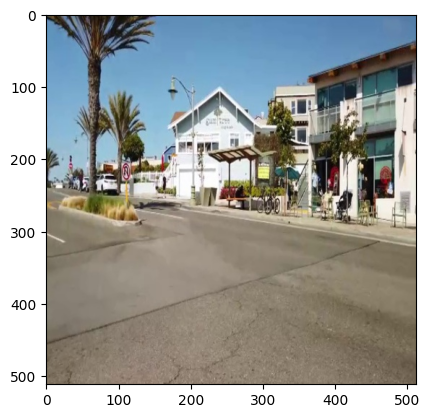

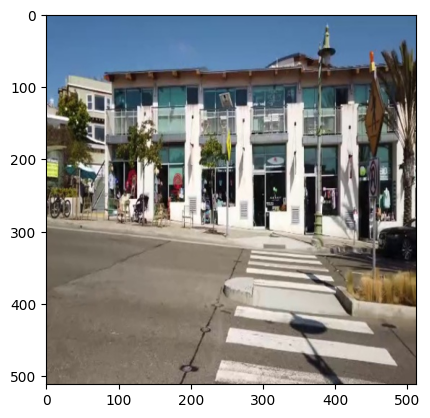

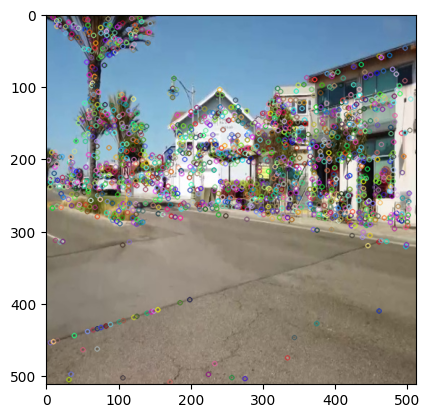

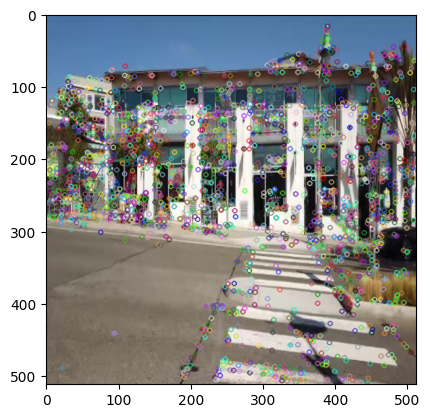

In [4]:
image1 = mpimg.imread("input1.jpg")
image2 = mpimg.imread("input2.jpg")

plt.figure()
plt.imshow(image1)
plt.savefig('image1.png', dpi = 300)

plt.figure()
plt.imshow(image2)
plt.savefig('image2.png', dpi = 300)

#  计算特征点提取&生成描述时间
start = time.time()
sift = cv2.SIFT_create()
#  使用SIFT查找关键点key points和描述符descriptors
kp1, des1 = sift.detectAndCompute(image1, None)
kp2, des2 = sift.detectAndCompute(image2, None)
end = time.time()
print("特征点提取&生成描述运行时间:%.2f秒"%(end-start))

kp_image1 = cv2.drawKeypoints(image1, kp1, None)
kp_image2 = cv2.drawKeypoints(image2, kp2, None)

plt.figure()
plt.imshow(kp_image1)
plt.savefig('kp_image1.png', dpi = 300)

plt.figure()
plt.imshow(kp_image2)
plt.savefig('kp_image2.png', dpi = 300)

In [5]:
print("关键点数目:", len(kp1))

for i in range(2):
    print("关键点", i)
    print("数据类型:", type(kp1[i]))
    print("关键点坐标:", kp1[i].pt)
    print("邻域直径:", kp1[i].size)
    print("方向:", kp1[i].angle)
    print("所在的图像金字塔的组:", kp1[i].octave)
    print("================")

#  查看描述
print("描述的shape:", des1.shape)
for i in range(2):
    print("描述", i)
    print(des1[i])

关键点数目: 1613
关键点 0
数据类型: <class 'cv2.KeyPoint'>
关键点坐标: (3.1212148666381836, 201.93138122558594)
邻域直径: 2.0152995586395264
方向: 22.88275146484375
所在的图像金字塔的组: 8323583
关键点 1
数据类型: <class 'cv2.KeyPoint'>
关键点坐标: (4.67941951751709, 228.42274475097656)
邻域直径: 2.741058111190796
方向: 296.0462951660156
所在的图像金字塔的组: 13894399
描述的shape: (1613, 128)
描述 0
[  5.  19.   7.  21.   4.   1.   3.   1.  96.  43.  10.  29.  12.   1.
   2.   1. 146.  52.   2.   8.  28.  11.   2.   5.  64.   3.   1.   9.
  54.  25.   8.  57.   1.   1.   0.   0.   0.  13.  18.   1.  85.  18.
   2.   6.  12.  76.  24.   6. 146.  66.   2.  17.  31.   5.   2.  12.
 142.   7.   1.  22.  48.   1.   2.  97.   0.   0.   0.   0.   0.   9.
   7.   0.  39.   0.   0.   1.  26. 146.  27.  22. 146.   9.   1.  11.
  24.  22.   7.  64. 146.  11.   3.  18.  24.   1.   2. 122.   0.   0.
   0.   0.   0.   0.   0.   0.  12.  13.  12.  13.  22.  19.   1.   4.
 114.  83.  13.  10.   9.   6.   1.  12. 146.  53.  33.  47.   7.   0.
   1.  11.]
描述 1
[  0.  

匹配点匹配运行时间:0.01秒
匹配对的数目: 349
匹配 0
数据类型: <class 'cv2.DMatch'>
描述符之间的距离: 199.94749450683594
查询图像中描述符的索引: 19
目标图像中描述符的索引: 296
匹配 1
数据类型: <class 'cv2.DMatch'>
描述符之间的距离: 117.34990692138672
查询图像中描述符的索引: 22
目标图像中描述符的索引: 316


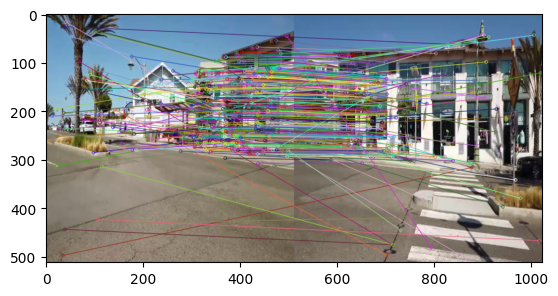

In [6]:
ratio = 0.85

#  计算匹配点匹配时间
start = time.time()

#  K近邻算法求取在空间中距离最近的K个数据点，并将这些数据点归为一类
matcher = cv2.BFMatcher()
raw_matches = matcher.knnMatch(des1, des2, k = 2)
good_matches = []
for m1, m2 in raw_matches:
    #  如果最接近和次接近的比值大于一个既定的值，那么我们保留这个最接近的值，认为它和其匹配的点为good_match
    if m1.distance < ratio * m2.distance:
        good_matches.append([m1])
end = time.time()
print("匹配点匹配运行时间:%.2f秒"%(end-start))

matches = cv2.drawMatchesKnn(image1, kp1, image2, kp2, good_matches, None, flags = 2)

plt.figure()
plt.imshow(matches)
plt.savefig('matches.png', dpi = 300)
print("匹配对的数目:", len(good_matches))
for i in range(2):
    print("匹配", i)
    print("数据类型:", type(good_matches[i][0]))
    print("描述符之间的距离:", good_matches[i][0].distance)
    print("查询图像中描述符的索引:", good_matches[i][0].queryIdx)
    print("目标图像中描述符的索引:", good_matches[i][0].trainIdx)
    print("================")


匹配运行时间:0.00秒


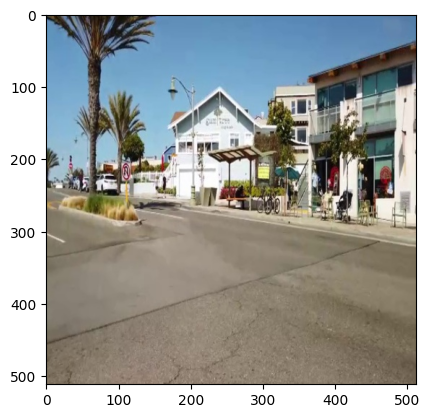

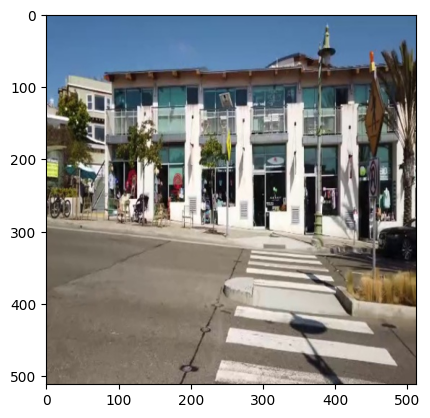

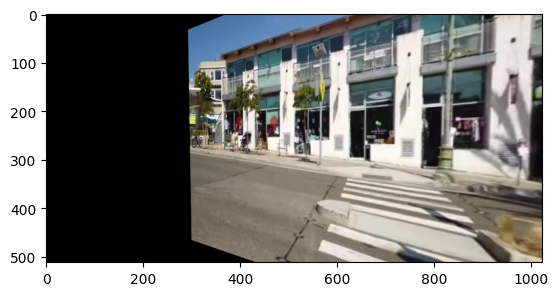

In [7]:
import numpy as np

#  单应性矩阵有八个参数，每一个对应的像素点可以产生2个方程(x一个，y一个)，那么需要四个像素点就能解出单应性矩阵
if len(good_matches) > 4:
    #  计算匹配时间
    start = time.time()
    ptsA= np.float32([kp1[m[0].queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    ptsB = np.float32([kp2[m[0].trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    ransacReprojThreshold = 4
    #  单应性矩阵可以将一张图通过旋转、变换等方式与另一张图对齐
    H, status =cv2.findHomography(ptsA,ptsB,cv2.RANSAC,ransacReprojThreshold);
    imgOut = cv2.warpPerspective(image2, H, (image1.shape[1]+image2.shape[1],image1.shape[0]),flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    end = time.time()
    print("匹配运行时间:%.2f秒"%(end-start))
    
    plt.figure()
    plt.imshow(image1)
    plt.figure()
    plt.imshow(image2)
    plt.figure()
    plt.imshow(imgOut)
    plt.savefig('imgOut.png', dpi = 300)